In [ ]:
!pip install konlpy

In [ ]:
import konlpy, re, tqdm, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from konlpy.tag import Okt

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import pandas as pd
import warnings; warnings.filterwarnings('ignore')


from google.colab import drive
drive.mount('/content/drive')
PATH ='/content/drive/MyDrive/dacon nlp/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train=pd.read_csv(PATH +'train.csv')
test=pd.read_csv(PATH +'test.csv')
sample_submission=pd.read_csv(PATH +'sample_submission.csv')

In [ ]:
# 결측치 확인.
# baseline ==> 과정명 변수만을 이용하여 학습하므로, 다른 변수의 결측은 제거나 대치하지 않고 진행.
train.isna().sum()

index           0
제출년도            0
사업명             0
사업_부처명          0
계속과제여부          0
내역사업명           0
과제명             0
요약문_연구목표     3002
요약문_연구내용     3001
요약문_기대효과     3051
요약문_한글키워드    3028
요약문_영문키워드    3087
label           0
dtype: int64

In [ ]:
import random
import pickle
import re

wordnet = {}
with open("/content/drive/MyDrive/dacon nlp/wordnet.pickle", "rb") as f:
	wordnet = pickle.load(f)


# 한글만 남기고 나머지는 삭제
def get_only_hangul(line):
	parseText= re.compile('/ ^[ㄱ-ㅎㅏ-ㅣ가-힣]*$/').sub('',line)

	return parseText



########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################
def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			num_replaced += 1
		if num_replaced >= n:
			break

	if len(new_words) != 0:
		sentence = ' '.join(new_words)
		new_words = sentence.split(" ")

	else:
		new_words = ""

	return new_words


def get_synonyms(word):
	synomyms = []

	try:
		for syn in wordnet[word]:
			for s in syn:
				synomyms.append(s)
	except:
		pass

	return synomyms

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################
def random_deletion(words, p):
	if len(words) == 1:
		return words

	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################
def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)

	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0

	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words

	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################
def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	
	return new_words


def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		if len(new_words) >= 1:
			random_word = new_words[random.randint(0, len(new_words)-1)]
			synonyms = get_synonyms(random_word)
			counter += 1
		else:
			random_word = ""

		if counter >= 10:
			return
		
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)



def EDA(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=3):
	sentence = get_only_hangul(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not ""]
	num_words = len(words)

	augmented_sentences = []
	num_new_per_technique = int(num_aug/4) + 1

	n_sr = max(1, int(alpha_sr*num_words))
	n_ri = max(1, int(alpha_ri*num_words))
	n_rs = max(1, int(alpha_rs*num_words))

	# sr
	for _ in range(num_new_per_technique):
		a_words = synonym_replacement(words, n_sr)
		augmented_sentences.append(' '.join(a_words))

	# ri
	for _ in range(num_new_per_technique):
		a_words = random_insertion(words, n_ri)
		augmented_sentences.append(' '.join(a_words))

	# rs
	for _ in range(num_new_per_technique):
		a_words = random_swap(words, n_rs)
		augmented_sentences.append(" ".join(a_words))

	# rd
	for _ in range(num_new_per_technique):
		a_words = random_deletion(words, p_rd)
		augmented_sentences.append(" ".join(a_words))

	augmented_sentences = [get_only_hangul(sentence) for sentence in augmented_sentences]
	random.shuffle(augmented_sentences)

	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	augmented_sentences.append(sentence)

	return augmented_sentences

In [ ]:
train[train["label"] != 0].shape

(31733, 13)

In [ ]:
train[train["label"] == 0].shape

(142571, 13)

In [ ]:
# label 값이 0 인 train 데이터
train_0 = train[train["label"] == 0]
# label 값이 0이 아닌 train 데이터
train_1 = train[train["label"] != 0]

In [ ]:
train_1_snt = train_1['사업명'] + ' ' + train_1['사업_부처명']

In [ ]:
train_0_snt = train_0['사업명'] + ' ' + train_0['사업_부처명']
train_0_label = train_0["label"]

In [ ]:
snt = []
label = []
for i in train_1_snt:
  snt += EDA(i)

for j in train_1["label"]:
  for _ in range(4):
    label.append(j)

print(len(snt))
print()
print(len(label))

126932

126932


In [ ]:
train_1_snt_eda = pd.Series(snt)
train_1_label_eda = pd.Series(label)

In [ ]:
# baseline ==> Feature : 사업명 + 과제명 이용토록 한다.
# x_train = train['사업명'] + ' ' + train['사업_부처명']
# y_train = train['label']
x_train = train['요약문_연구목표']
y_train = train['label']
x_test  = test['요약문_연구목표']

# from sklearn.model_selection import train_test_split
# df_train, df_test=train_test_split(train, test_size=0.3, random_state=4321)

# Shape of dataset.
print(f'x_train shape: { x_train.shape }')
print(f'y_train shape: { y_train.shape }')
print(f'x_test shape:  { x_test.shape }' )

x_train shape: (174304,)
y_train shape: (174304,)
x_test shape:  (43576,)


In [ ]:
# text 정제 함수 생성 : 한글 이외의 문자는 전부 제거함.
def Preprocessing(text, tagger, remove_stopwords=False, stop_words=[]) :
    # 한글 정규식 정의(띄어쓰기, ㄱ ~ ㅣ, 가 ~ 힣)
    text = re.sub('[^ ㄱ-ㅣ가-힣]+','',text)
    
    # 텍스트를 형태소로 분리후 각 단어로부터 어간을 추출.(stem=True)
    word_text = tagger.morphs(text, stem=True)
    
    # 불용어 처리.
    if remove_stopwords :
        word_text = [ t for t in word_text if not t in stop_words ]
        
    return word_text

# 한글 불용어 사전 파일 이용.
with open('/content/drive/MyDrive/dacon nlp/korean_stopwords.txt', encoding='utf-8') as fp :
    stop_words = fp.readlines()
    
# \n 제거.
stop_words = [ x.strip() for x in stop_words ]
# print(stop_words)
# print('-'*135)
# print()

# Okt 이용.
tagger = Okt()

# train, test 데이터를 정제한 텍스트를 담을 리스트 생성.
Clean_train_data = []
Clean_test_data  = []

# Train dataset 정제 작업 시작.
for text in tqdm.tqdm(x_train) :
    try :
        Clean_train_data.append(Preprocessing(text, tagger, remove_stopwords=True, stop_words=stop_words))
    except :
        Clean_train_data.append([])

# est dataset 정제 작업 시작.
for text in tqdm.tqdm(x_test) :
    if type(text) == str :
        Clean_test_data.append(Preprocessing(text, tagger, remove_stopwords=True, stop_words=stop_words))
    else :
        Clean_test_data.append([])   
        
# 정제된 데이터의 수.
print(f'Train data : {len(Clean_train_data)}')
print(f'Test data  : {len(Clean_test_data)}')

100%|██████████| 43576/43576 [24:47<00:00, 29.30it/s]

Train data : 174304
Test data  : 43576


In [ ]:
# 우선 특별한 옵션을 지정하지 않고 진행.
token = Tokenizer()

# fit_on_texts() : 입력으로 들어온 텍스트에서 단어의 빈도수가 높은 순으로 낮은 숫자부터 인덱스 부여, 단어 집합 생성.
token.fit_on_texts(Clean_train_data)

# 단어 사전을 통해 문장의 각 단어를 숫자(시퀀스 형태)로 변환. : 인덱스로만 채워진 새로운 배열을 생성한다는 의미.
Train_squences = token.texts_to_sequences(Clean_train_data)
Test_squences  = token.texts_to_sequences(Clean_test_data)

# 한 문장의 최대 단어 수를 가져옴.
max_cnt = 0
for c in Train_squences :
    # 현재 문장의 글자수.
    cnt = len(c)
    # 현재 문장의 글자수가 이전 최대 수치보다 많으면 덮어쓰기.
    if max_cnt < cnt :
        max_cnt = cnt
print(f'최대 단어의 개수 : {max_cnt}')

# Padding 처리 : 서로 길이가 다른 리스트의 개수를 max_cnt로 맞춰줌.
# 끝 부분으로 적용. ==> 즉 max_cnt 길이의 리스트로 동일하게 맞춰주기 위해 부족한 부분으로 뒤에서 부터 0으로 채우는 작업을 의미.
padded_train = pad_sequences(Train_squences, max_cnt, padding='post')
padded_test  = pad_sequences(Test_squences, max_cnt, padding='post')

# One-hot-encoding.
# 주의 : 맨 앞에 0이 추가됨.
voca_size = len(token.word_index) + 1
# train_x = to_categorical(Train_squences, num_classes = voca_size)
# test_x  = to_categorical(Test_squences, num_classes = voca_size)

최대 단어의 개수 : 689


In [ ]:
padded_train = np.load(#경로)
padded_test  = np.load()

In [ ]:
#추후 재사용 가능하도록 npy로 전환
import json

DATA_IN_PATH='/content/drive/MyDrive/dacon nlp/train_data/f5/'
TRAIN_INPUT_DATA = 'train_input_f5.npy'
TEST_INPUT_DATA = 'test_input_f5.npy'

import os
if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)
    
np.save(open(DATA_IN_PATH+TRAIN_INPUT_DATA, 'wb'), padded_train)
np.save(open(DATA_IN_PATH+TEST_INPUT_DATA, 'wb'), padded_test)

data_configs={}
data_configs['vocab']=token.word_index
data_configs['vocab_size'] = voca_size
json.dump(data_configs, open(DATA_IN_PATH+'data_configs.json', 'w'), ensure_ascii=False)

In [ ]:
# Modeling.

# 학습 모델을 구성.
model = Sequential()

# word embedding : 데이터 공간의 효율성을 위해 주어진 배열을 정해진 길이로 압축하는 작업.
# keras의 Embedding 함수는 오차역전파 방식으로 각 단어 간의 최적의 유사도를 계산.
model.add(Embedding(voca_size, 32, input_length = max_cnt))

# 임시 데이터에 대한 글로벌 평균 풀링 작업.?
model.add(GlobalAveragePooling1D())
model.add(Dense(128, activation = 'relu'))

# 다변량 라베링에 대한 결과이므로 Softmax 통과. 0, 1(0이 아닌)에 대한 이진 결과로 보고자할 시 Sigmoid로 통과.
model.add(Dense(46, activation = 'softmax'))
# model.summary()

# 컴파일.
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# 모델 저장 폴더 설정.
model_dir = '/content/drive/MyDrive/dacon nlp/models/f5'

# 해당 폴더가 존재하지 않으면 생성.
if not os.path.isdir(model_dir) :                                                           
    os.mkdir(model_dir)
    
# Callback 조건 설정.
model_path = model_dir+'{epoch}-{val_loss}.hdf5'

# Validation Loss를 기준으로 조건 판단.
callback1 = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)

# 이전 가장 좋은 결과 대비 10회 이상 후에도 향상 되는 결과가 나오지 않을시 학습 중단.
callback2 = EarlyStopping(monitor = 'val_loss', patience=10)

# 모델 학습.
history = model.fit(padded_train, y_train, validation_split = 0.2, epochs = 30, verbose = 0, callbacks = [callback1, callback2])


Epoch 00001: val_loss improved from inf to 0.89972, saving model to /content/drive/MyDrive/dacon nlp/models/f51-0.8997244238853455.hdf5

Epoch 00002: val_loss improved from 0.89972 to 0.78890, saving model to /content/drive/MyDrive/dacon nlp/models/f52-0.788901150226593.hdf5

Epoch 00003: val_loss improved from 0.78890 to 0.70368, saving model to /content/drive/MyDrive/dacon nlp/models/f53-0.7036790251731873.hdf5

Epoch 00004: val_loss improved from 0.70368 to 0.65382, saving model to /content/drive/MyDrive/dacon nlp/models/f54-0.6538187265396118.hdf5

Epoch 00005: val_loss improved from 0.65382 to 0.61789, saving model to /content/drive/MyDrive/dacon nlp/models/f55-0.6178860068321228.hdf5

Epoch 00006: val_loss improved from 0.61789 to 0.60250, saving model to /content/drive/MyDrive/dacon nlp/models/f56-0.6024996638298035.hdf5

Epoch 00007: val_loss did not improve from 0.60250

Epoch 00008: val_loss improved from 0.60250 to 0.59139, saving model to /content/drive/MyDrive/dacon nlp/m

In [ ]:
# 성능 최적의 모델 로딩.
# 모델 폴더의 가장 마지막에 위치한 파일명 입력.
best_model = load_model('/content/drive/MyDrive/dacon nlp/models/f512-0.5462183356285095.hdf5')
best_model.evaluate(padded_train, y_train)[1]

5447/5447 [==============================] - 14s 3ms/step - loss: 0.3218 - accuracy: 0.9128


0.912773072719574

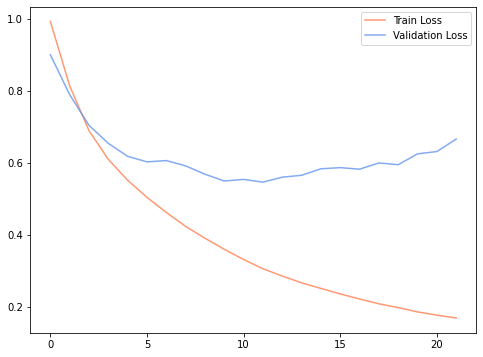

In [ ]:
# Train Loss
y_loss = history.history['loss']
# Validation Loss
y_vloss = history.history['val_loss']

plt.figure(figsize=(8,6))
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss,  label='Train Loss', c='coral', alpha=.8)
plt.plot(x_len, y_vloss,  label='Validation Loss', c='cornflowerblue', alpha=.8)
plt.legend()
plt.show()

In [ ]:
pred = best_model.predict(padded_test)
pred = tf.argmax(pred, axis = 1)

df = pd.read_csv('/content/drive/MyDrive/dacon nlp/sample_submission.csv')
df['label'] = pred
df.to_csv('/content/drive/MyDrive/dacon nlp/testmodel/f5_Baseline_test1.csv', index=False)

In [ ]:
pd.read_csv('/content/drive/MyDrive/dacon nlp/testmodel/f5_Baseline_test1.csv')

,index,label
0,174304,0
1,174305,0
2,174306,0
3,174307,0
4,174308,1
...,...,...
43571,217875,0
43572,217876,0
43573,217877,2
43574,217878,0
